# **Model 1**

제작 : 성현<br>
사용 기법 : CNN<br>


> **모델 간략한 소개**

1. lr schedule<br>
2. early stopping<br>
3. dropout<br>

> **모델 성능**

ACC : **88.99%** <br>
LOSS : **0.2780** <br>
F1 SCORE : **0.8881789137380192** <br>

모델 학습 시 loss, val_loss, acc, val_acc 그래프 아래 첨부할 것.

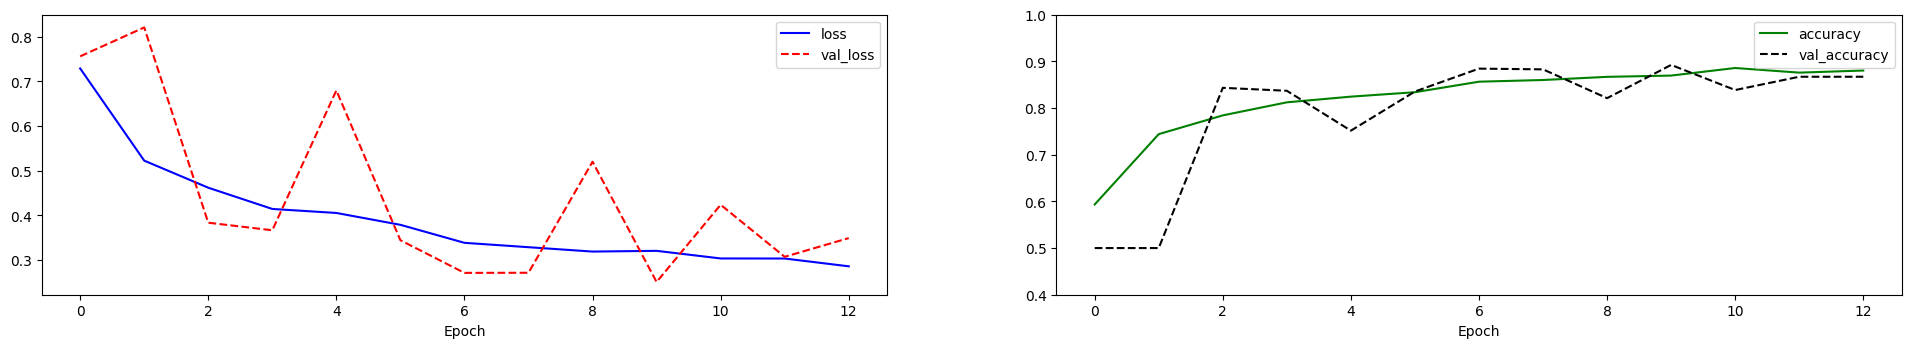

### **GPU 설정**

In [1]:
import tensorflow as tf

# GPU 디바이스 확인
tf.test.gpu_device_name()

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# TensorFlow가 GPU를 사용할 수 있도록 설정합니다.
if len(tf.config.list_physical_devices('GPU')) > 0:
    print('GPU is enabled')
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)


Num GPUs Available:  1
GPU is enabled


### **모듈 import**

In [2]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

### **프로젝트 공통 설정**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
test_data_path = '/content/drive/MyDrive/PneumoniaClassifier/data/test'
val_data_path = '/content/drive/MyDrive/PneumoniaClassifier/data/val'
train_data_path = '/content/drive/MyDrive/PneumoniaClassifier/data/train'

In [5]:
def count_data_number(path, name):
    pneumonia = 0
    normal = 0

    # pneumonia 폴더 내의 파일 개수 계산
    pneumonia_path = os.path.join(path, 'PNEUMONIA')
    if os.path.exists(pneumonia_path):
        pneumonia = len(os.listdir(pneumonia_path))

    # normal 폴더 내의 파일 개수 계산
    normal_path = os.path.join(path, 'NORMAL')
    if os.path.exists(normal_path):
        normal = len(os.listdir(normal_path))

    print(name, "pneumonia data : ", pneumonia)
    print(name, "normal data : ", normal)
    print()

    return pneumonia, normal

In [6]:
count_data_number(train_data_path, "train")
count_data_number(val_data_path, "val")
count_data_number(test_data_path, "test")

train pneumonia data :  1108
train normal data :  1108

val pneumonia data :  316
val normal data :  316

test pneumonia data :  159
test normal data :  159



(159, 159)

## **모델 개발**

In [7]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img)) #, cv2.IMREAD_GRAYSCALE
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                # 이미지 배열의 크기가 예상된 형태로 재조정
                resized_arr = np.reshape(resized_arr, (img_size, img_size, 3))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [8]:
# 훈련 데이터 생성
train_data = get_training_data(train_data_path)

# 테스트 데이터 생성
test_data = get_training_data(test_data_path)

# 검증 데이터 생성
val_data = get_training_data(val_data_path)


<ipython-input-7-f1f49e35e60e>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [9]:
X_train = np.array([item[0] for item in train_data])  # 이미지 데이터
y_train = np.array([item[1] for item in train_data])  # 레이블

X_test = np.array([item[0] for item in test_data])    # 이미지 데이터
y_test = np.array([item[1] for item in test_data])    # 레이블

X_val = np.array([item[0] for item in val_data])      # 이미지 데이터
y_val = np.array([item[1] for item in val_data])      # 레이블

# 데이터 shape 확인
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)

X_train shape: (2216, 200, 200, 3)
y_train shape: (2216,)
X_test shape: (318, 200, 200, 3)
y_test shape: (318,)
X_val shape: (632, 200, 200, 3)
y_val shape: (632,)


In [10]:
X_train = X_train / 255.
X_test = X_test / 255.
X_val = X_val / 255.

In [11]:
# good for balancing out disproportions in the dataset
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True)

datagen.fit(X_train)

In [12]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=(200, 200, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten())

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))


initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=lr_schedule)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 256)     7168      
                                                                 
 activation (Activation)     (None, 200, 200, 256)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 256)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 256)    400       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      147520    
                                                                 
 activation_1 (Activation)   (None, 100, 100, 64)      0

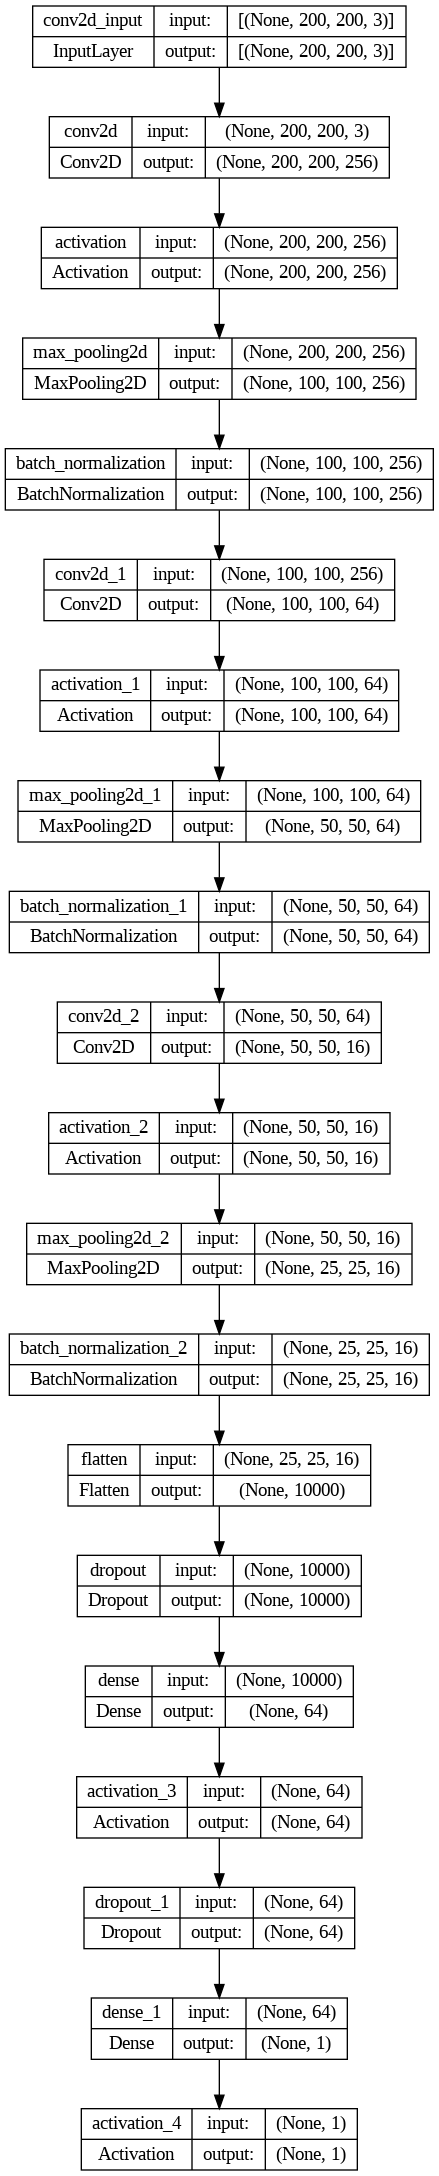

In [14]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=10), callbacks=[early_stop], validation_data=(X_val, y_val), epochs=15)

Epoch 1/15
222/222 [==============================] - 48s 150ms/step - loss: 0.7288 - acc: 0.5934 - val_loss: 0.7558 - val_acc: 0.5000
Epoch 2/15
222/222 [==============================] - 28s 128ms/step - loss: 0.5226 - acc: 0.7441 - val_loss: 0.8205 - val_acc: 0.5000
Epoch 3/15
222/222 [==============================] - 31s 141ms/step - loss: 0.4621 - acc: 0.7843 - val_loss: 0.3838 - val_acc: 0.8434
Epoch 4/15
222/222 [==============================] - 28s 127ms/step - loss: 0.4145 - acc: 0.8123 - val_loss: 0.3669 - val_acc: 0.8370
Epoch 5/15
222/222 [==============================] - 28s 128ms/step - loss: 0.4056 - acc: 0.8245 - val_loss: 0.6795 - val_acc: 0.7516
Epoch 6/15
222/222 [==============================] - 28s 126ms/step - loss: 0.3790 - acc: 0.8339 - val_loss: 0.3446 - val_acc: 0.8354
Epoch 7/15
222/222 [==============================] - 30s 135ms/step - loss: 0.3388 - acc: 0.8565 - val_loss: 0.2715 - val_acc: 0.8845
Epoch 8/15
222/222 [==============================] - 2

In [ ]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 2s 188ms/step - loss: 0.2780 - acc: 0.8899


[0.2779536247253418, 0.8899371027946472]

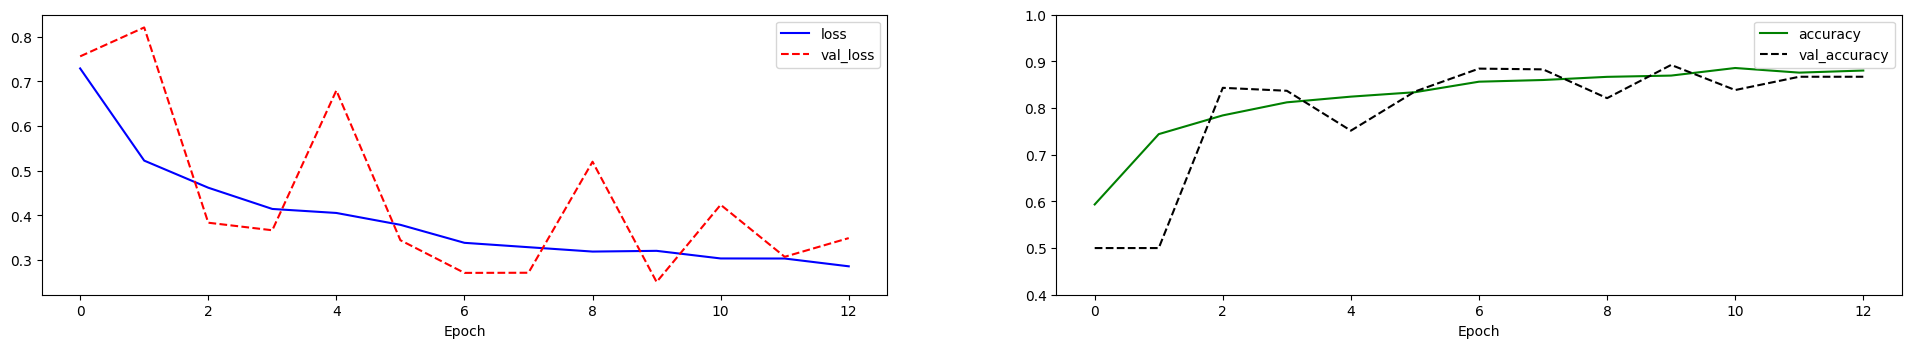

In [ ]:
plt.figure(figsize=(24,8))

plt.subplot(2,2,1)
plt.plot(history.history['loss'],'b-',label='loss')
plt.plot(history.history['val_loss'],'r--',label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2,2,2)
plt.plot(history.history['acc'],'g-',label='accuracy')
plt.plot(history.history['val_acc'],'k--',label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.4,1.0)
plt.legend()

In [ ]:
# 모델 저장
model.save('/content/drive/MyDrive/PneumoniaClassifier/model/model1.h5')

## **모델 평가**


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# 모델 예측
y_pred = model.predict(X_test)
# 임계값 설정 및 이진 레이블로 변환
y_pred_binary = (y_pred > 0.5).astype(int)

# F1 점수 계산
f1 = f1_score(y_test, y_pred_binary)

print('F1 Score:', f1)

10/10 [==============================] - 1s 49ms/step
F1 Score: 0.8881789137380192
